## 1st session - alpha algorithm

- 알파알고리즘을 구현해봤습니다. 
- 알파알고리즘은 이벤트 로그로부터 페트리넷을 뽑아내는 알고리즘입니다. 
- 사실, Process mining같은 책에서 제시하는 기본 알파 알고리즘의 경우는
    - activity의 frequency를 고려하지 않는데, 예를 들어서 1번이 나오든 10000번이 나오든 모두 반영되고
    - loop, non-local dependency를 고려하지 않는 것 등의 문제가 있긴 합니다. 
        - non-local dependency: 직접 연결되어 있지 않은 액티비티 간의 관계
            - (a, c, d), (b, c, f): a ==> d, b ==> f는 관계되어 있지만, 직접 연결되어 있지 않음
- 아무튼, 그래도, 제일 먼저 나온 알고리즘이라서 구현을 해봤습니다. 
- BPI challenge log 같은 복잡하고, 많은 데이터를 가지고 하는 것보다는, 우선 간단한 예로 보기 편할 것 같아서, 간단한 예제로 만들어 봤습니다. 

## required library

- `matplotlib.pyplot`: 그림 그리는 라이브러리(페트리넷 그릴 때 사용)
- `datetime`: 파이썬에서 쓰는 시간, 날짜 관리 라이브러리(오늘은 사용하지 않음)
- `networkx`: 프로세스 모델도 업무간의 관계를 표현한 데이터 구조이고, 이를 효과적으로 담기 위해서는 네트워크를 관리하기 위한 라이브러리가 필요함
- `itertools`, `functools`: 몇 가지 유용한 툴
- `time`: computation time logging을 위한 툴 
- `seaborn`: 그림을 좀 더 예쁘게 만들어주는 라이브러리, 경우에 따라서 그냥 import 만 해줘도, 없을때보다 예쁘게 만들어줌 

In [1]:
%matplotlib inline 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import networkx as nx
import itertools as ittls
import functools 
import numpy as np
import time

## toy_example
- 간단하게 쓸 수 있는 toy example을 만들었습니다. 
- 2-dimension lst, each element is activity trace

In [4]:
log5 = [['a', 'b', 'e', 'f']]*2 + [['a', 'b', 'e', 'c', 'd', 'b', 'f']]*3 + [['a', 'b', 'c', 'e', 'd', 'b', 'f']]*2
log5 += [['a', 'b', 'c', 'd', 'e', 'b', 'f']]*4 + [['a', 'e', 'b', 'c', 'd', 'b', 'f']]*3
for i, trace in enumerate(log5):
    print("{} trace: {}".format(i+1, trace))

1 trace: ['a', 'b', 'e', 'f']
2 trace: ['a', 'b', 'e', 'f']
3 trace: ['a', 'b', 'e', 'c', 'd', 'b', 'f']
4 trace: ['a', 'b', 'e', 'c', 'd', 'b', 'f']
5 trace: ['a', 'b', 'e', 'c', 'd', 'b', 'f']
6 trace: ['a', 'b', 'c', 'e', 'd', 'b', 'f']
7 trace: ['a', 'b', 'c', 'e', 'd', 'b', 'f']
8 trace: ['a', 'b', 'c', 'd', 'e', 'b', 'f']
9 trace: ['a', 'b', 'c', 'd', 'e', 'b', 'f']
10 trace: ['a', 'b', 'c', 'd', 'e', 'b', 'f']
11 trace: ['a', 'b', 'c', 'd', 'e', 'b', 'f']
12 trace: ['a', 'e', 'b', 'c', 'd', 'b', 'f']
13 trace: ['a', 'e', 'b', 'c', 'd', 'b', 'f']
14 trace: ['a', 'e', 'b', 'c', 'd', 'b', 'f']


In [9]:
test_log = log5*500

def return_unique_activities(input_log):
    uniq_act = []
    for trace in input_log:
        for act in trace:
            if act in uniq_act:
                continue
            else:
                uniq_act.append(act)
    return uniq_act


## causality matrix
- causality matrix: 액티비티 간의 관계를 표현한 매트릭스
    - `->`: direct succession
    - `||`: parellel
    - `->`: reverse direct succession
    - `#` : no relation 

- trace에서 연속된 act1, act2를 모두 뽑아서, return 해주는 함수

In [10]:
def return_all_direct_succession(input_log):
    return [ (instance[i], instance[i+1]) for instance in input_log for i in range(0, len(instance)-1) ]

- `causality matrix`를 리턴해주는 함수 
    - 이 함수의 경우는 `pd.DataFrame`를 리턴해줍니다. 여기서 문제는 
    - 2-dim dictionary를 `pd.DataFrame` 로 변환할 때, 상위 key가 column name으로, 하위 key가 row index로 변환됩니다. 
        - 상위 키: from activity, 하위 키: to activity
    - 그런데, 우리의 경우 해당 테이블에서, 왼쪽이 from, 오른쪽이 to 이므로, `transpose()`로 변환해서 리턴합니다. 

In [11]:
def causality_matrix(input_log):
    uniq_activity = return_unique_activities(input_log)
    dir_successions = return_all_direct_succession(input_log)
    
    causality_matrix = { key1: {}for key1 in uniq_activity}
    for a1 in uniq_activity:
        for a2 in uniq_activity:
            if (a1, a2) in dir_successions and (a2, a1) in dir_successions:
                causality_matrix[a1][a2]="||"
            elif (a1, a2) in dir_successions and (a2, a1) not in dir_successions:
                causality_matrix[a1][a2]="->"
            elif (a1, a2) not in dir_successions and (a2, a1) in dir_successions:
                causality_matrix[a1][a2]="<-"
            else:
                causality_matrix[a1][a2]="#"
    return pd.DataFrame(causality_matrix).transpose()
    # 2-dim dictionary 를 pd.DataFrame로 변환할 때, 상위 키가 column name으로, 하위 키가 row_name으로 감
    # 따라서, 리턴할 때는 transpose로 변환해주는 것이 필요함. 
causality_matrix(log5)

,a,b,c,d,e,f
a,#,->,#,#,->,#
b,<-,#,->,<-,||,->
c,#,<-,#,->,||,#
d,#,->,<-,#,||,#
e,<-,||,||,||,#,->
f,#,<-,#,#,<-,#


## pd.DataFrame indexing
- 그냥 indexing하면, column index => row index로 진행됨
- `.loc()`를 붙이고 indexing해야, row index => column index

In [339]:
a = causality_matrix(log5)

print(a)
print( a['a']['b'])
print( a.loc()['a']['b'])
print( a.index )
print( a.columns )

computation time: 0.0
    a   b   c   d   e   f
a   #  ->   #   #  ->   #
b  <-   #  ->  <-  ||  ->
c   #  <-   #  ->  ||   #
d   #  ->  <-   #  ||   #
e  <-  ||  ||  ||   #  ->
f   #  <-   #   #  <-   #
<-
->
Index(['a', 'b', 'c', 'd', 'e', 'f'], dtype='object')
Index(['a', 'b', 'c', 'd', 'e', 'f'], dtype='object')


## alpha algorithm

- 자 이제 알파알고리즘을 만들어 봅시다. 
- 알고리즘에 대해서 자세히 설명 하지는 않겠지만, 대충 이렇습니다. 
    https://en.wikipedia.org/wiki/Petri_net
    - Transition: activity
    - Place
    - Flow
- 설명하기 귀찮으니까 그냥 안할게요...

In [12]:
def return_transitions(input_log):
    T_L = return_unique_activities(input_log)
    T_I = list(set( [instance[0] for instance in input_log]))
    T_O = list(set( [instance[-1] for instance in input_log]))
    return (T_L, T_I, T_O)

- place를 뽑기 위해서는 우선, 어떤 transion들이 어떤 transition들로 연속되는가를 알아야 합니다. 
- 이를 위해서는 우선 transition의 가능한 모든 subset을 뽑는게 필요하죠. 
    - subset1 => subset2인 모든 가능한 경우를 뽑아야 합니다. 
- 이를 위해 우선, 가능한 모든 subset을 리턴해주는 함수를 만듭니다. 

In [13]:
def find_subsets(lst):
    # A, B 내부 집단의 a끼리, b끼리는 관계가 없고, 모든 a, 모든 b 간에는 direct succession이 있는 것들
    subsets = [list(ittls.combinations(lst, i)) for i in range(1, len(lst)+1)]
    subsets = functools.reduce(lambda x, y: x+y, subsets)
    return subsets

- 그 다음에는 place가 될 수 있는 subset을 뽑습니다. 
    - subset A, B에서 A의 모든 a와 B의 모든 b 간에는 direct relation이 있어야 하고
    - 개별 subset에서 각각 A, B에서 a끼리는 모두 #이어야 하고, b끼리고 모두 #이어야 합니다.

In [14]:
def return_X_L(input_log):
    T_L, T_I, T_O = return_transitions(input_log)
    c_matrix = causality_matrix(input_log)
    A_s = find_subsets(T_L)[:-1]# remove last item
    AB_s = [(A, B) for A in A_s for B in find_subsets( list(set(T_L) - set(A)) )]
    def check_direction(A, B):
        return all( c_matrix.loc()[a][b]=="->" for a in A for b in B)
    def check_no_relation(A, B):
        return all( c_matrix.loc()[a][b]=="#" for a in A for b in B)
    AB_s = filter(lambda AB: check_direction(AB[0], AB[1]), AB_s)
    AB_s = filter(lambda AB: check_no_relation(AB[0], AB[0]), AB_s)
    AB_s = filter(lambda AB: check_no_relation(AB[1], AB[1]), AB_s)
    X_L = list(AB_s)
    return X_L

### return_Y_L
- 이제 가능한 모든 place, X_L을 모두 만들었는데, X_L의 element, x에도 subset이 있을 수 있습니다. 
    - ((a), (b))는 ((a, c), (b))의 subset이죠. 그래서 이러한 subset을 모두 없애고, ((a, c), (b))만 남기면 X_L 이 Y_L이 됩니다. 

In [15]:
def return_Y_L(input_log):
    # make it maximal
    X_L = return_X_L(input_log)
    Y_L = X_L.copy()
    remove_lst =[]
    for i in range(0, len(X_L)-1):
        for j in range(i+1, len(X_L)):
            if set(X_L[i][0]).issubset(set(X_L[j][0])):
                if set(X_L[i][1]).issubset(set(X_L[j][1])):
                    if X_L[i] not in remove_lst:
                        remove_lst.append(X_L[i])
    for rem_elem in remove_lst:
        Y_L.remove(rem_elem)
    return Y_L

### return_P_L

- 따라서, Y_L이 각각 place가 됩니다. 
    - 그리고, P_L에서 attribute dictionary에 해당 place가 어떤 transition들로부터 연결되어, 어떤 transition들로 연결되어 가는지를 함께 저장해줍니다. 
    - 이렇게 해놓아야, 이후 Flow에서 활용할 수 있습니다. 
- 각 place 이름을  순서대로, P1,P2,...로 정하고, sink, source를 추가해줍니다. 

In [16]:
def return_P_L(input_log):
    T_L, T_I, T_O = return_transitions(input_log)
    Y_L = return_Y_L(input_log)
    P_L = [("P"+str(i+1), {"From":Y_L[i][0], "To":Y_L[i][1]}) for i in range(0, len(Y_L))]
    P_L.insert(0, ("source", {"From":(), "To":[elem for elem in T_I]}))
    P_L.append(("sink", {"From":[elem for elem in T_O], "To":()}))
    return P_L

### return_F_L
- P_L에 저장해준 attr_dict를 통해 place와 transition간의 edge를 모두 도출하고 리스트로 만들어 리턴해줍니다. 

In [17]:
def return_F_L(input_log):
    P_L = return_P_L(input_log)
    F_L = [(a, p_name) for p_name, p_attr in P_L for a in p_attr["From"]]
    F_L +=[(p_name, a) for p_name, p_attr in P_L for a in p_attr["To"]]
    return F_L

### alpha_algorithm

- 지금까지 만든 함수를 모두 만들어서 돌려줍니당 호호

In [18]:
def alpha_algorithm(input_log):
    T_L, T_I, T_O = return_transitions(input_log)
    P_L = return_P_L(input_log)
    F_L = return_F_L(input_log)

    return (P_L, T_L, F_L)
                
        
P_L, T_L, F_L = alpha_algorithm(log5)
print("Places:")
print(P_L)
print("Transitions:")
print(T_L)
print("Flows:")
print(F_L)

Places:
[('source', {'From': (), 'To': ['a']}), ('P1', {'From': ('a',), 'To': ('e',)}), ('P2', {'From': ('b',), 'To': ('c', 'f')}), ('P3', {'From': ('e',), 'To': ('f',)}), ('P4', {'From': ('c',), 'To': ('d',)}), ('P5', {'From': ('a', 'd'), 'To': ('b',)}), ('sink', {'From': ['f'], 'To': ()})]
Transitions:
['a', 'b', 'e', 'f', 'c', 'd']
Flows:
[('a', 'P1'), ('b', 'P2'), ('e', 'P3'), ('c', 'P4'), ('a', 'P5'), ('d', 'P5'), ('f', 'sink'), ('source', 'a'), ('P1', 'e'), ('P2', 'c'), ('P2', 'f'), ('P3', 'f'), ('P4', 'd'), ('P5', 'b')]


### make directional Graph from P, T, F

- 이제 Place, transition, flow로부터 graph를 만들어줍니다 
- nx.DiGraph()는 방향성이 있는 그래프이고, 따라서, petri-net같은 자료를 저장하기 좋습니다. 

In [19]:
P_L, T_L, F_L = alpha_algorithm(log5)

import networkx as nx
DG = nx.DiGraph()
DG.add_nodes_from([(T, {"Type":"transition"}) for T in T_L])
DG.add_nodes_from([ (P[0], {"Type":"place"}) for P in P_L])
DG.add_edges_from(F_L)
DG.nodes(data=True)

NodeDataView({'a': {'Type': 'transition'}, 'b': {'Type': 'transition'}, 'e': {'Type': 'transition'}, 'f': {'Type': 'transition'}, 'c': {'Type': 'transition'}, 'd': {'Type': 'transition'}, 'source': {'Type': 'place'}, 'P1': {'Type': 'place'}, 'P2': {'Type': 'place'}, 'P3': {'Type': 'place'}, 'P4': {'Type': 'place'}, 'P5': {'Type': 'place'}, 'sink': {'Type': 'place'}})

## 이제 그림을 그려봅시다 

- position: 개별 점들이 어디에 위치해야 하는가? 
    - 그래프를 그릴 때는 점들의 포지션이 어디에 있어야 하는지가 중요합니다. 이를 layout이라고 하는데, 어떻게 표현해줘야 심미적으로 이쁠까? 혹은 사람이 직관적으로 이해할까? 는 매우 중요한 이슈죠. 
    - 저는 그냥 nx.spectral_layout을 이용해서 그렸습니다. 
- edge: nx.draw_networkx_edges로 일괄적으로 그려줍니다. 
    - default 화살표가 썩 마음에 들지는 않지만 어쩔수 없습니다. 
        - 이건 제가 밑에서 다른 방식을 하나 더 소개시켜드릴게요. 
- node: 노드의 경우, transition, place 별로 모양이 다르고, place도 sink, source도 다르게 표현해주기 위해서, 개별적으로 그려줍니다. 
    - `plt.scatter`를 활용해서 매번 점을 하나씩 찍어줍니다. 

In [25]:
def draw_petri_net(DG, node_pos):
    plt.figure(figsize=(10, 10))
    pos = node_pos
    node_size_lst = [ 100 if node[0]!="source" and node[0]!="sink" else 500 for node in DG.nodes(data=True)]
    node_shape_lst = [ "o" if node[1]["Type"]=="place" else "s" for node in DG.nodes(data=True)]

    nx.draw_networkx_edges(DG, pos)
    nx.draw_networkx_labels(DG, pos, font_color='white')
    for node in DG.nodes(data=True):
        node_shape = "s" if node[1]["Type"]=="transition" else "o"
        node_color = "blue" if node[1]["Type"]=="transition" else "red" if node[0]=="sink" or node[0]=="source" else "green"
        node_size  = 500 if node[0]!="source" and node[0]!="sink" else 1500
        plt.scatter(pos[node[0]][0], pos[node[0]][1], s=node_size, c=node_color, marker=node_shape)
        #nx.draw_networkx_nodes(DG, pos[node[0]], nodelist=node)
    plt.axis('off')

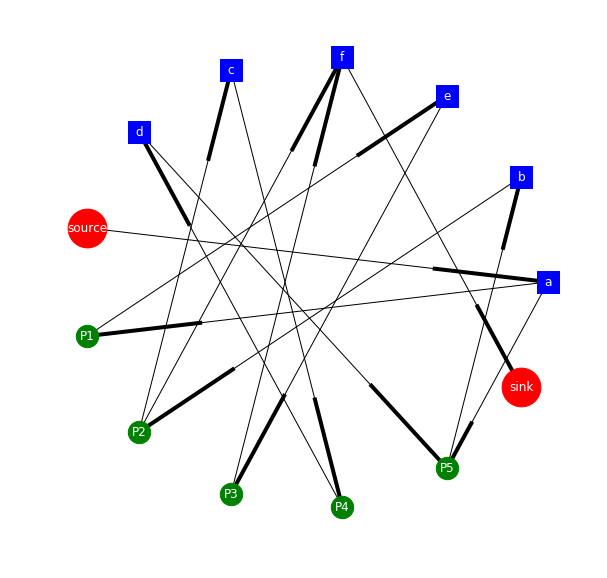

In [26]:
draw_petri_net(DG, nx.shell_layout(DG))
plt.savefig("../../assets/images/markdown_img/alpha_shell_layout.png")

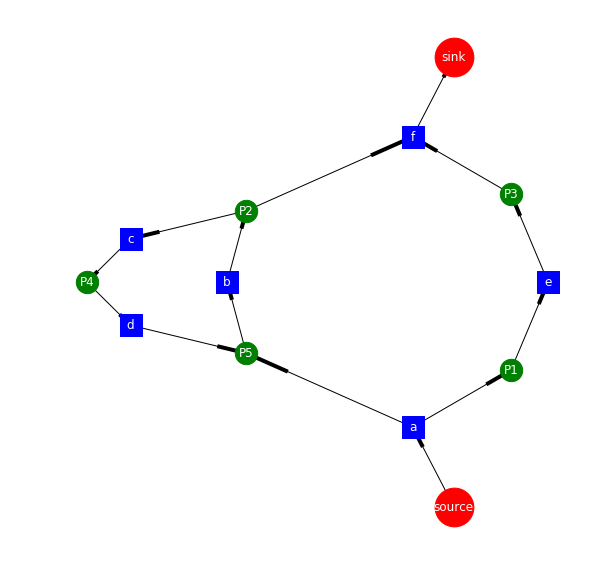

In [27]:
draw_petri_net(DG, nx.spectral_layout(DG))
plt.savefig("../../assets/images/markdown_img/alpha_spectral_layout.png")

## arrow 
- `nx.draw_networkx_edges(DG, pos)`에서는 edge가 예쁘게 그려지지는 않는 것 같아요
- `matplotlib`에 있는 `ax.arrow`를 활용해서 그려봅니다. 
    - arrow 의 경우는, vector처럼, (x, y, dx, dy, head_width, head_length) 로 조절합니다. 
    - 사실 이 부분때문에 node위에 arrow가 그려지는 경우가 많아서 조금 불편하긴 해요.
        - 이걸 좀 고쳐보고 싶었는데 잘 안되네요...ㅠㅠ
        - http://matthiaseisen.com/matplotlib/shapes/arrow/

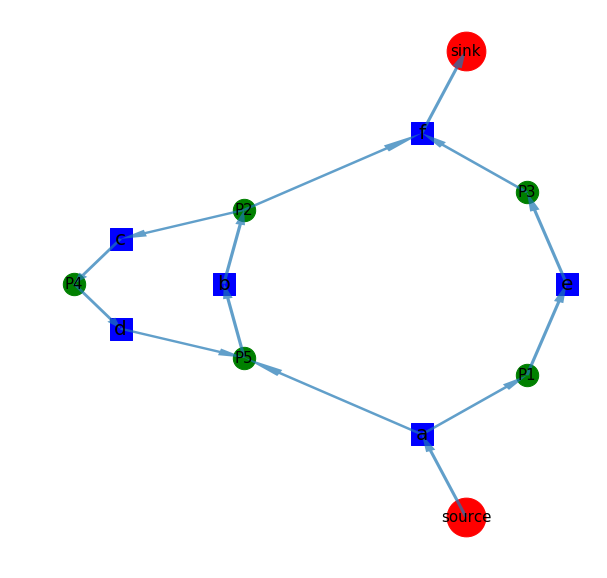

In [28]:
def draw_petri_net_arrow(DG, node_pos):
    import matplotlib.patches as patches
    plt.figure(figsize=(10, 10))
    pos = node_pos
    node_size_lst = [ 100 if node[0]!="source" and node[0]!="sink" else 500 for node in DG.nodes(data=True)]
    node_shape_lst = [ "o" if node[1]["Type"]=="place" else "s" for node in DG.nodes(data=True)]
        
    #nx.draw_networkx_labels(DG, pos, font_color='white')
    ax = plt.gca()
    for node in DG.nodes(data=True):
        node_shape = "s" if node[1]["Type"]=="transition" else "o"
        node_color = "blue" if node[1]["Type"]=="transition" else "red" if node[0]=="sink" or node[0]=="source" else "green"
        node_size  = 500 if node[0]!="source" and node[0]!="sink" else 1500
        plt.scatter(pos[node[0]][0], pos[node[0]][1], s=node_size, c=node_color, marker=node_shape)
        
        font_size  = 20 if node[1]["Type"]=="transition" else 15
        ax.annotate(node[0], xy=(pos[node[0]][0], pos[node[0]][1]), xytext=(pos[node[0]][0], pos[node[0]][1]),
                    fontsize=font_size, horizontalalignment='center', verticalalignment='center')
        #nx.draw_networkx_nodes(DG, pos[node[0]], nodelist=node)
        
    #ax.add_patch( patches.Arrow(0.3, 0.2, 0, 0.5, width=0.1, hatch='/') )
    for edge in DG.edges(data=True):
        from_node = pos[edge[0]]
        to_node = pos[edge[1]]
        x, y = from_node[0], from_node[1]
        dx, dy = to_node[0] - from_node[0], to_node[1] - from_node[1]
        #arr1 = ax.arrow(x, y, dx*0.9, dy*0.9, head_width=0.02, head_length=0.02, fc='k', ec='k')
        arr2 = patches.Arrow(x, y, dx, dy, width=0.05, alpha=0.7) 
        ax.add_patch(arr2)
    plt.axis('off')
draw_petri_net_arrow(DG, nx.spectral_layout(DG))
plt.savefig("../../assets/images/markdown_img/alpha_spectral_layout_with_new_arrow.png")

## 그리고.

- 엄청 복잡한, 그래서 액티비티의 수가 엄청 많은 경우에도 해당 그림이 예쁘게 잘 그려질까요??
    - 그때 적합한 layout은 무엇이 있을까요. 
- 지금은 가장 간단한 알파 알고리즘을 구현했습니다. 